# NLE and Nested Sampling

Neural Likelihood Estimation (NLE) is a simulation-based inference method that focuses on estimating the likelihood function directly using neural networks. This approach is particularly useful when the likelihood is complex or intractable, allowing for efficient parameter inference.

NLE must be combined with a sampling method to draw samples from the posterior distribution. Nested Sampling is one such method that is well-suited for this purpose, as it efficiently explores the parameter space and estimates the evidence. Evidence estimation is crucial for model comparison and selection in Bayesian inference.

Note that the following code currently requires a custom fork of the blackjax library which include nested sampling functionality. This fork can be installed via pip:

```bash
pip install git+https://github.com/handley-lab/blackjax
```

The following implementation of NLE combined with Nested Sampling is taken from here: https://handley-lab.co.uk/nested-sampling-book/sbi/nle_posterior.html

In [9]:
from typing import Optional

import anesthetic
import blackjax
import jax
import jax.numpy as jnp
import numpy as np
import torch
import tqdm
from blackjax.ns.utils import finalise
from sbi.inference.posteriors.base_posterior import NeuralPosterior
from sbi.inference.potentials.likelihood_based_potential import LikelihoodBasedPotential


class NSPosterior(NeuralPosterior):
    """Nested Sampling posterior for sbi.

    Uses BlackJAX nested sampling to sample from posterior distributions
    when given a likelihood estimator and prior.

    Args:
        likelihood: Trained likelihood estimator from NLE
        prior: Prior distribution
        num_live: Number of live points for nested sampling
        num_inner_steps: Number of slice sampling steps
        x_o: Observed data (can be set later with set_default_x)
        num_delete: Number of points to delete per iteration (default: 1)
    """

    def __init__(
        self,
        likelihood,
        prior,
        num_live,
        num_inner_steps,
        x_o=None,
        num_delete=1,
        columns=None,
    ):
        """Initialize NSPosterior instance.

        Args:
            likelihood: Trained likelihood estimator from NLE
            prior: Prior distribution
            num_live: Number of live points for nested sampling
            num_inner_steps: Number of slice sampling steps
            x_o: Observed data (can be set later with set_default_x)
            num_delete: Number of points to delete per iteration (default: 1)
            columns: List of column names for anesthetic NestedSamples object
        """
        self.num_live = num_live
        self.num_delete = num_delete
        self.num_inner_steps = num_inner_steps
        self.columns = columns

        potential_fn = LikelihoodBasedPotential(likelihood, prior, x_o)
        super().__init__(potential_fn)

    def _loglikelihood_fn(self, theta):
        """Compute log-likelihood for BlackJAX nested sampling."""
        x_o_batch = self.default_x.unsqueeze(0).expand(1, theta.shape[0], -1)
        return self.potential_fn.likelihood_estimator.log_prob(x_o_batch, condition=theta).squeeze(
            0
        )

    def _logprior_fn(self, theta):
        """Compute log-prior for BlackJAX nested sampling."""
        return self.potential_fn.prior.log_prob(theta)

    def nested_samples(self) -> anesthetic.NestedSamples:
        """Run BlackJAX nested sampling and return anesthetic NestedSamples object.

        Returns:
            NestedSamples object containing particles, log-likelihoods, and birth
            log-likelihoods that can be used for evidence calculation and diagnostics.
        """

        def wrap_fn(fn, vmap_method="legacy_vectorized"):
            """Wrap a PyTorch function to be JAX-compatible using jax.pure_callback."""

            def numpy_wrapper(theta):
                """Convert inputs and outputs between JAX and PyTorch/numpy."""
                x = torch.from_numpy(np.asarray(theta).copy()).float()
                result = fn(x)
                return result.detach().numpy()

            def jax_wrapper(x):
                """JAX wrapper that uses pure_callback to call numpy_wrapper."""
                out_shape = jax.ShapeDtypeStruct(x.shape[:-1], x.dtype)
                return jax.pure_callback(numpy_wrapper, out_shape, x, vmap_method=vmap_method)

            return jax_wrapper

        algo = blackjax.nss(
            logprior_fn=wrap_fn(self._logprior_fn),
            loglikelihood_fn=wrap_fn(self._loglikelihood_fn),
            num_delete=self.num_delete,
            num_inner_steps=self.num_inner_steps,
        )
        prior_samples = self.potential_fn.prior.sample((self.num_live,))
        initial_live = jnp.array(prior_samples)

        rng_key = jax.random.PRNGKey(42)
        live = algo.init(initial_live)
        step = jax.jit(algo.step)

        dead_points = []

        with tqdm.tqdm(desc="Dead points", unit=" dead points") as pbar:
            while not live.logZ_live - live.logZ < -3:
                rng_key, subkey = jax.random.split(rng_key)
                live, dead = step(subkey, live)
                dead_points.append(dead)
                pbar.update(len(dead.particles))

        ns_run = finalise(live, dead_points)

        return anesthetic.NestedSamples(
            data=ns_run.particles,
            logL=ns_run.loglikelihood,
            logL_birth=ns_run.loglikelihood_birth,
            columns=self.columns,
        )

    def sample(
        self, sample_shape: torch.Size = torch.Size(), x: Optional[torch.Tensor] = None, **kwargs
    ) -> torch.Tensor:
        r"""Return samples from posterior distribution $p(\theta|x)$ with nested sampling.

        Check the `__init__()` method for a description of all arguments as well as
        their default values.

        Args:
            sample_shape: Desired shape of samples that are drawn from posterior. If
                sample_shape is multidimensional we simply draw `sample_shape.numel()`
                samples and then reshape into the desired shape.
            x: Observation to condition on. If None, uses default_x set via
                `set_default_x()`.
            kwargs: Additional keyword arguments (not used).

        Returns:
            Samples from posterior with shape `(*sample_shape, theta_dim)`.
        """
        self.potential_fn.set_x(self._x_else_default_x(x))
        ns = self.nested_samples()
        samples = ns.sample(torch.Size(sample_shape).numel())
        samples_array = samples.drop(columns=["logL", "logL_birth", "nlive"]).values
        return torch.from_numpy(samples_array).reshape((*sample_shape, -1))

    def sample_batched(self, sample_shape, x, **kwargs):
        """Placeholder for batched sampling (not implemented)."""
        raise NotImplementedError("Batched sampling not available for nested sampling.")

A brief summary of the key parameters used in the nested sampling implementation:
- n_live – the number of live points, typically set to some multiple of the dimension of the parameter space, 25x D is a good starting point
- num_inner_steps – the length of the short Markov chains used to update the population, typically set to some multiple of the dimension of the parameter space, 3x D is a good starting point
- num_delete – some integer [1 - n_live], how many chains to vectorize over, setting this to approximately 10% of n_live is likely good for CPU usage, Up to 50% for GPU

We can now load in a previously trained NLE model. In Synference, an NLE model can be trained in the same way as an NLE model, by using the `SBI_Fitter` class with the `engine='NLE'` argument. Here, we load in a previously trained NLE model from disk.

We can access the likelihood estimator from the trained model using the `likelihood_func` property of the `SBI_Fitter` class.

We will demonstate the utility of NLE for model comparison by comparing two different stellar population synthesis models: BPASS and FSPS. We will load in previously trained NLE models for both BPASS and FSPS, and use Nested Sampling to draw samples from the posterior distribution for a given observed data point. We will then compute the evidence for each model using the samples drawn from the posterior.


In [5]:
import os

from anesthetic import NestedSamples
from pandas import read_csv

from synference import SBI_Fitter

bpass_model = SBI_Fitter.load_saved_model("BPASS_NLE_v4", device="cpu")

prior_bpass = bpass_model.create_priors()

posterior_bpass = NSPosterior(
    bpass_model.likelihood_func,
    prior_bpass,
    num_live=1000,
    num_inner_steps=30,
    num_delete=100,
    columns=bpass_model.fitted_parameter_names,
)

fsps_model = SBI_Fitter.load_saved_model("FSPS_NLE_v4", device="cpu")
prior_fsps = fsps_model.create_priors()

posterior_fsps = NSPosterior(
    fsps_model.likelihood_func,
    prior_fsps,
    num_live=1000,
    num_inner_steps=30,
    num_delete=100,
    columns=fsps_model.fitted_parameter_names,
)

x_o_fsps = fsps_model._X_test[1]

2025-11-05 17:36:46,934 | synference | WARNING  | Error loading HDF5 file /cosma/apps/dp276/dc-harv3/synference/grids/grid_BPASS_Chab_DenseBasis_SFH_0.01_z_14_logN_5.0_Calzetti_v3_multinode.hdf5: [Errno 2] No such file or directory: '/cosma/apps/dp276/dc-harv3/synference/grids'Won't be able to fit model without grid.
2025-11-05 17:36:48,607 | synference | INFO     | Loaded model from /Users/user/Documents/PhD/synference/models/BPASS_NLE_v4/BPASS_NLE_nsf_nle_posterior.pkl.
2025-11-05 17:36:48,608 | synference | INFO     | Device: cpu
2025-11-05 17:36:49,010 | synference | INFO     | ---------------------------------------------
2025-11-05 17:36:49,011 | synference | INFO     | Prior ranges:
2025-11-05 17:36:49,012 | synference | INFO     | ---------------------------------------------
2025-11-05 17:36:49,012 | synference | INFO     | log_mass: 4.00 - 12.00 [log10_Msun]
2025-11-05 17:36:49,013 | synference | INFO     | log10metallicity: -4.00 - -1.39 [log10(Zmet)]
2025-11-05 17:36:49,013

Here is our chosen observed data point from the FSPS test set.

We set our observed data for sampling using the `.set_default_x()` method of the `NSPosterior` class. We can then draw samples and compute evidences from the posterior using the `.nested_samples()` method.

We can then compute Bayes factor, the ratio of evidences, to compare the two models. A Bayes factor greater than 1 indicates that the data favors the BPASS model over the FSPS model, while a Bayes factor less than 1 indicates the opposite.

In [6]:
import os
import numpy as np
from pandas import read_csv

if not os.path.exists("bpass_nested_samples.csv"):
    posterior_bpass.set_default_x(x_o_fsps)
    bpass_samples = posterior_bpass.nested_samples()
    bpass_samples.to_csv("bpass_nested_samples.csv")
else:
    bpass_samples = NestedSamples(read_csv("bpass_nested_samples.csv"))


print(f"Evidence for BPASS: {bpass_samples.logZ().mean():.2f} ± {bpass_samples.logZ().std():.2f}")

if not os.path.exists("fsps_nested_samples.csv"):
    posterior_fsps.set_default_x(x_o_fsps)
    fsps_samples = posterior_fsps.nested_samples()
    fsps_samples.to_csv("fsps_nested_samples.csv")
else:
    fsps_samples = NestedSamples(read_csv("fsps_nested_samples.csv"))


print(f"Evidence for FSPS: {fsps_samples.logZ().mean():.2f} ± {fsps_samples.logZ().std():.2f}")

bayes_factor = np.exp(fsps_samples.logZ().mean() - bpass_samples.logZ().mean())
print(f"Bayes factor (FSPS / BPASS): {bayes_factor:.2f}")

Evidence for BPASS: 28.92 ± 0.00
Evidence for FSPS: 29.83 ± 0.00
Bayes factor (FSPS / BPASS): 2.49


We can plot the corner plot of the samples using the `anesthetic` package as follows:

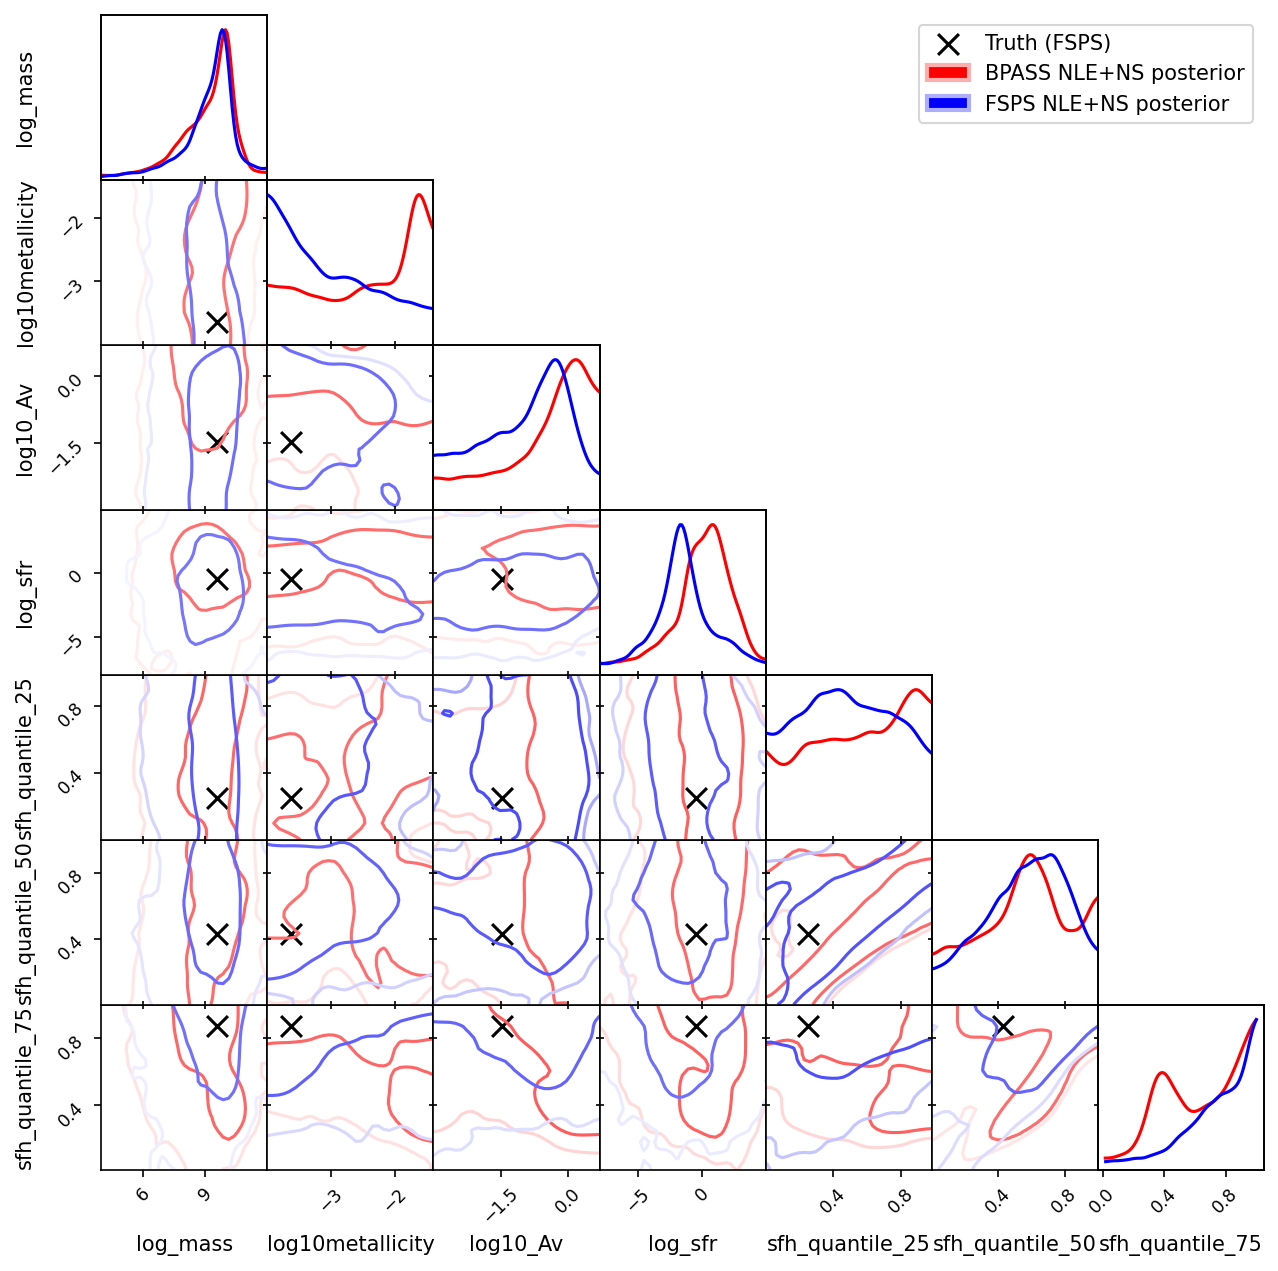

In [38]:
from anesthetic import make_2d_axes
from matplotlib import pyplot as plt

plt.rcParams.update({"figure.dpi": 150})

params = [
    "log_mass",
    "log10metallicity",
    "log10_Av",
    "log_sfr",
    "sfh_quantile_25",
    "sfh_quantile_50",
    "sfh_quantile_75",
]
fig, axes = make_2d_axes(params, upper=False, figsize=(10, 10))

truth = fsps_model._y_test[1]
axes.scatter(
    {param: truth[i] for i, param in enumerate(params)},
    c="black",
    marker="x",
    s=100,
    label="Truth (FSPS)",
)
bpass_samples.plot_2d(axes, c="red", fc=None, label="BPASS NLE+NS posterior")
fsps_samples.plot_2d(axes, c="blue", fc=None, label="FSPS NLE+NS posterior")

axes.iloc[-1, 0].legend(loc="upper right", bbox_to_anchor=(len(axes), len(axes)))

We can compare this to a trained NPE model as well, which will directly provide posterior samples.

In [8]:
from synference import load_unc_model_from_hdf5

grid_path = "../example_models/bpass_db_v4/grid_BPASS_Chab_DenseBasis_SFH_0.01_z_14_logN_2.7_Calzetti_v3_multinode.hdf5"  # noqa: E501

fitter = SBI_Fitter.load_saved_model(
    model_file="../example_models/bpass_db_v4", grid_path=grid_path, device="cpu"
)

nm_path = (
    "../example_models/bpass_db_v4/BPASS_DenseBasis_v4_final_nsf_0_params_empirical_noise_models.h5"
)
noise_models = load_unc_model_from_hdf5(nm_path)

fitter.feature_array_flags["empirical_noise_models"] = noise_models

2025-11-05 17:40:10,967 | synference | INFO     | Loaded model from ../example_models/bpass_db_v4/BPASS_DenseBasis_v4_final_nsf_0_posterior.pkl.
2025-11-05 17:40:10,981 | synference | INFO     | Device: cpu
2025-11-05 17:40:11,049 | synference | WARNING  | IndexError when trying to set train/test arrays. 


In [26]:
samples = fitter.sample_posterior(x_o_fsps)

Sampling from posterior: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


Now we can load our NPE samples into anesthetic and plot the corner plot for comparison.

In [36]:
from anesthetic.samples import Samples

num_samples = samples.shape[0]
params = fsps_model.fitted_parameter_names[:7]
samples = samples[:, :7]
num_dim = samples.shape[1]

npe_samples = Samples(
    data=samples,
    columns=params,
)

Here is the corner plot comparison of NPE (using a BPASS model) and NLE + Nested Sampling (using a FSPS model and a BPASS model). The test data point was generated from the FSPS model, so we expect the NLE + Nested Sampling with FSPS to perform better than the NPE with BPASS.

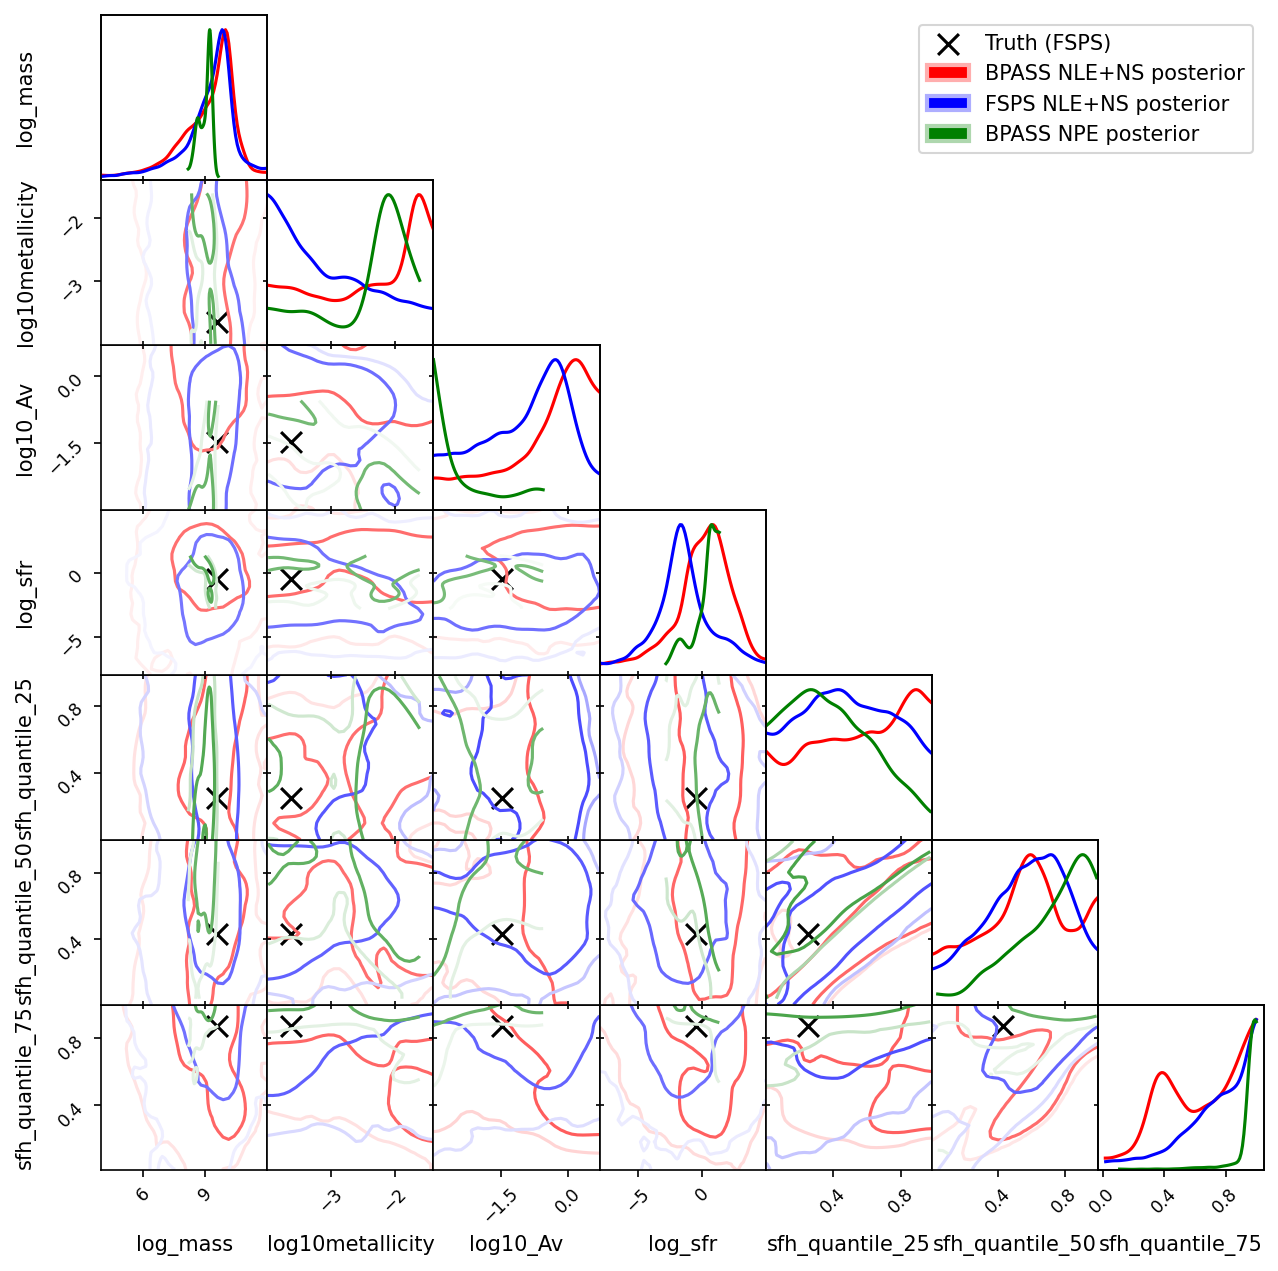

In [39]:
npe_samples.plot_2d(axes, c="green", fc=None, label="BPASS NPE posterior")
axes.iloc[-1, 0].legend(loc="upper right", bbox_to_anchor=(len(axes), len(axes)))

fig

In [40]:
fig.savefig("/Users/user/Downloads/nle_example.png", bbox_inches="tight", dpi=300)